In [44]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.data_io import create_time_bins, get_cam_timestamps, load_ONE, get_experiment_path, get_dlc_df, get_rotary_position, temporally_align_variable, preprocess_dlc_data
from utils.behavioral_analysis import calculate_median_position
from utils.visualization import plot_single_session, plot_all_sessions, plot_sorted_spike_counts, plot_PCA, plot_correlation_distributions, plot_dlc_analyses
from utils.pipeline import load_and_process_session, analyze_single_session, analyze_multiple_sessions
from utils.statistical_testing import categorise_neurons
from utils.correlation_analysis import run_PCA, get_correlations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace as Bunch
import seaborn as sns
from scipy.stats import binned_statistic_2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
subject_id = "AV043"
my_sessions = [
    ('AV043', '2024-03-04'),
    ('AV043', '2024-03-05'),
    ('AV043', '2024-03-08'),
    ('AV043', '2024-03-11'),
    ('AV043', '2024-03-13'),
    ('AV043', '2024-03-14'),
    ('AV043', '2024-03-26'),
    ('EB036', '2024-03-20'),
    ('EB036', '2024-03-22'),
    ('EB037', '2024-03-20'),
    ('EB037', '2024-03-21'),
    ('EB037', '2024-03-22'),
    ('GB011', '2024-05-09'),
    ('GB011', '2024-05-10'),
    ('GB011', '2024-05-14'),
    ('GB011', '2024-05-15'),
    ('GB011', '2024-05-16'),
    ('GB011', '2024-05-17'),
    ('GB012', '2024-06-20'),
    ('GB012', '2024-06-21'),
    ('GB012', '2024-06-25'),
    ('GB012', '2024-07-12'),
    ('GB012', '2024-07-16'),

    
]




    

In [152]:
subject_id = 'EB037'
date = '2024-03-20'

In [153]:
sesh =load_and_process_session(subject_id, date, target_freq=10)
sesh = analyze_single_session(sesh)
plot_single_session(sesh)



Error accessing \\zortex.cortexlab.net\Subjects\EB037\2024-03-20\1: Unable to allocate 19.1 MiB for an array with shape (2507000,) and data type float64


TypeError: '>=' not supported between instances of 'float' and 'NoneType'

In [145]:
print(len(sesh.spike_counts[1]))
session_length = len(sesh.spike_counts[1])
halfpoint = int(session_length / 2)
print(halfpoint)

oa_pos = sesh.oa_pos
wh_pos = sesh.wh_pos

print(len(np.flatnonzero(oa_pos[:halfpoint])))
print(len(np.flatnonzero(wh_pos[:halfpoint])))
print(len(np.flatnonzero(oa_pos[halfpoint:])))
print(len(np.flatnonzero(wh_pos[halfpoint:])))

print(len(np.flatnonzero(sesh.spike_counts[:,:halfpoint])))
print(len(np.flatnonzero(sesh.spike_counts[:, halfpoint:])))


25089
12544
5350
6580
6292
5602
104626
2301950


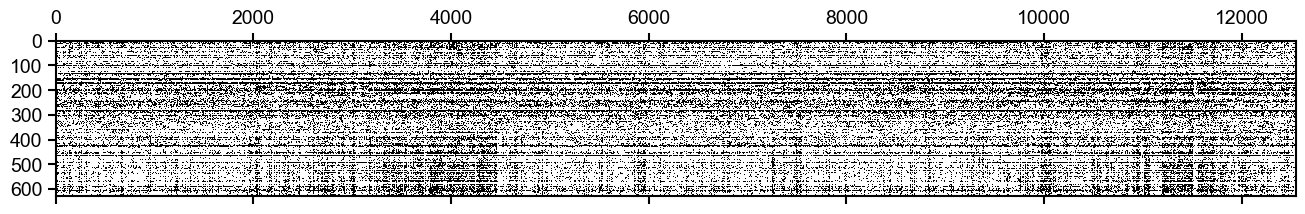

In [149]:
plt.matshow(sesh.spike_counts[:,halfpoint :], aspect= "auto", cmap='gray_r', vmin=0, vmax=np.percentile(sesh.spike_counts, 85), interpolation="none")


In [81]:
print(sesh.wh_speed)

[ 0.  0.  0. ... nan nan nan]


In [48]:
r_oa, r_wh = get_correlations(sesh.spike_counts, sesh.oa_speed, sesh.wh_speed, sesh.oa_pos, sesh.wh_pos, filter=False)

In [50]:
print(r_oa)
print(np.where(np.isnan(r_oa)))

[ 5.14419693e-02  2.22763759e-02 -9.67953519e-02 -9.23710612e-02
 -2.75888886e-02  2.66857506e-02 -1.09948438e-02 -5.37521770e-02
 -5.41686961e-02 -1.76707100e-02 -1.52128176e-01 -5.35778749e-02
 -1.63951664e-01 -9.83003211e-02 -1.39378358e-01 -5.77448393e-02
 -5.52317334e-02 -8.12571209e-02 -9.53709861e-02 -1.19149407e-01
 -2.61871181e-02 -2.37908747e-02 -7.87398512e-02 -8.44144490e-02
 -1.41903287e-01  1.82494056e-02  3.66045846e-02 -1.50810540e-01
 -5.40393909e-02 -6.23132839e-02 -2.41178338e-03 -6.05898079e-02
 -6.31795434e-02 -1.89322490e-02 -6.76605615e-02  2.56130634e-02
 -1.68788717e-01 -9.03919726e-02 -4.09718047e-02  8.21776099e-03
 -7.19603956e-02 -7.77122346e-02 -7.93395453e-02 -6.36957439e-02
 -1.48950135e-01 -1.32381703e-01 -5.51401101e-02 -3.87581764e-02
  1.49393965e-01  4.12740083e-02  2.40340345e-03 -6.12621167e-02
 -5.63015827e-02 -8.85788402e-02 -4.40649793e-02  2.13970955e-01
 -1.40979239e-04 -1.38526797e-02  3.60629522e-02  1.15909062e-02
  8.93290704e-03 -1.95540

In [43]:
print(sesh.spike_counts.shape)

(667, 40129)


In [ ]:
all_sessions = analyze_multiple_sessions(my_sessions)




In [ ]:
plot_all_sessions(all_sessions)

In [408]:
sesh = all_sessions[8]
print(len(sesh.context_invariant))
print(len(sesh.spike_counts))

564
564


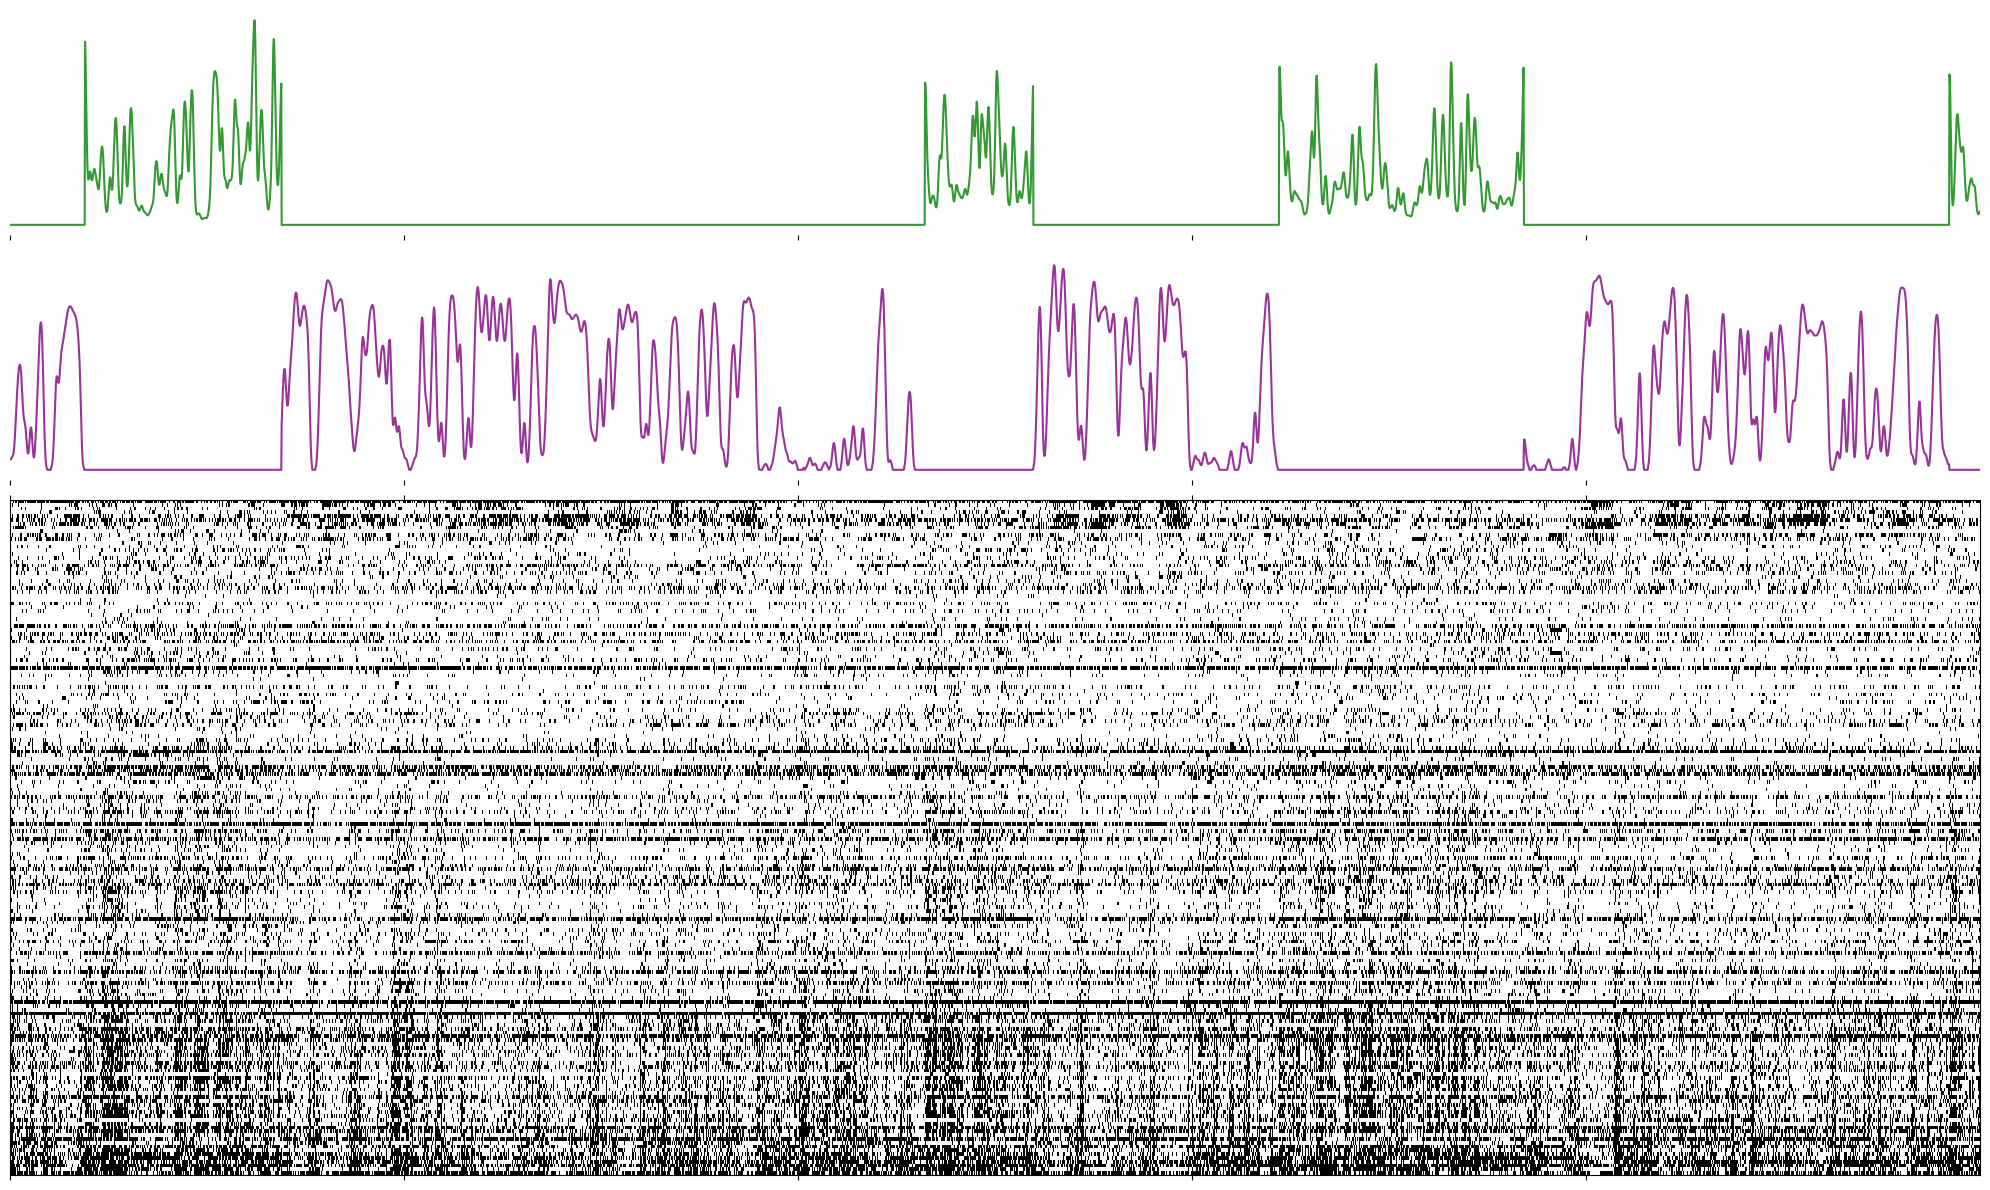

In [265]:


plot_sorted_spike_counts(sesh.r_wh[sesh.wheel_only], sesh.oa_speed, sesh.wh_speed, sesh.wh_running, sesh.oa_running, sesh.spike_counts[sesh.wheel_only,:], w_start=0, w_end=5000)



In [426]:
for session in all_sessions:
    n_neurons = session.spike_counts.shape[0]

    oa_speed_bins = np.linspace(0, np.nanmax(session.oa_speed), num=10)
    oa_speed_bin_centers = 0.5 * (oa_speed_bins[:-1] + oa_speed_bins[1:])
    wh_speed_bins = np.linspace(0, np.nanmax(session.wh_speed), num=10)
    wh_speed_bin_centers = 0.5 * (wh_speed_bins[:-1] + wh_speed_bins[1:])


    oa_firing_rates = np.zeros((n_neurons, len(oa_speed_bin_centers)))
    oa_speed_indices = np.digitize(session.oa_speed, oa_speed_bins) -1
    wh_firing_rates = np.zeros((n_neurons, len(wh_speed_bin_centers)))
    wh_speed_indices = np.digitize(session.wh_speed, wh_speed_bins) -1

    dt = 0.1


    for i in range (len(oa_speed_bin_centers)):
        idx =oa_speed_indices == i
        if np.any(idx):
            occupancy = np.sum(idx) * dt
            spikes_in_bin = session.spike_counts[:,idx].sum(axis=1)
            oa_firing_rates[:,i] = spikes_in_bin / occupancy
        else:
            oa_firing_rates[:,i] = np.nan


    for i in range (len(wh_speed_bin_centers)):
        idx =wh_speed_indices == i
        if np.any(idx):
            occupancy = np.sum(idx) * dt
            spikes_in_bin = session.spike_counts[:,idx].sum(axis=1)
            wh_firing_rates[:,i] = spikes_in_bin / occupancy
        else:
            wh_firing_rates[:,i] = np.nan

    slopes_oa = np.zeros(n_neurons)
    offsets_oa = np.zeros(n_neurons)
    r2_oa = np.zeros(n_neurons)
    slopes_wh = np.zeros(n_neurons)
    offsets_wh = np.zeros(n_neurons)
    r2_wh = np.zeros(n_neurons)

    for neuron in range(n_neurons):

        valid_oa = ~np.isnan(oa_firing_rates[neuron])
        valid_wh = ~np.isnan(wh_firing_rates[neuron])

        if np.sum(valid_oa) > 3:
            slopes_oa[neuron], offsets_oa[neuron] = np.polyfit(oa_speed_bin_centers[valid_oa], oa_firing_rates[neuron, valid_oa], 1)
            r2_oa[neuron] =1 - np.sum((oa_firing_rates[neuron, valid_oa] - (slopes_oa[neuron] * oa_speed_bin_centers[valid_oa] + offsets_oa[neuron]))**2) / np.sum((oa_firing_rates[neuron, valid_oa] - np.nanmean(oa_firing_rates[neuron, valid_oa]))**2)
        
        else:
            slopes_oa[neuron] = np.nan
            offsets_oa[neuron] = np.nan
            r2_oa[neuron] = np.nan

        if np.sum(valid_wh) > 3:
            slopes_wh[neuron], offsets_wh[neuron] = np.polyfit(wh_speed_bin_centers[valid_wh], wh_firing_rates[neuron, valid_wh], 1)
            r2_wh[neuron] =1 - np.sum((wh_firing_rates[neuron, valid_wh] - (slopes_wh[neuron] * wh_speed_bin_centers[valid_wh] + offsets_wh[neuron]))**2) / np.sum((wh_firing_rates[neuron, valid_wh] - np.nanmean(wh_firing_rates[neuron, valid_wh]))**2)
        
        else:
            slopes_wh[neuron] = np.nan
            offsets_wh[neuron] = np.nan
            r2_wh[neuron] = np.nan

    session.oa_slope = slopes_oa
    session.oa_offset = offsets_oa
    session.oa_r2 = r2_oa
    session.wh_slope = slopes_wh
    session.wh_offset = offsets_wh
    session.wh_r2 = r2_wh


In [ ]:
for session in all_sessions:
    n_neurons = session.spike_counts.shape[0]

slopes_oa = np.zeros(n_neurons)
offsets_oa = np.zeros(n_neurons)
r2_oa = np.zeros(n_neurons)
slopes_wh = np.zeros(n_neurons)
offsets_wh = np.zeros(n_neurons)
r2_wh = np.zeros(n_neurons)

for neuron in range(n_neurons):

    valid_oa = ~np.isnan(oa_firing_rates[neuron])
    valid_wh = ~np.isnan(wh_firing_rates[neuron])

    if np.sum(valid_oa) > 3:
        slopes_oa[neuron], offsets_oa[neuron] = np.polyfit(oa_speed_bin_centers[valid_oa], oa_firing_rates[neuron, valid_oa], 1)
        r2_oa[neuron] =1 - np.sum((oa_firing_rates[neuron, valid_oa] - (slopes_oa[neuron] * oa_speed_bin_centers[valid_oa] + offsets_oa[neuron]))**2) / np.sum((oa_firing_rates[neuron, valid_oa] - np.nanmean(oa_firing_rates[neuron, valid_oa]))**2)
        
    else:
        slopes_oa[neuron] = np.nan
        offsets_oa[neuron] = np.nan
        r2_oa[neuron] = np.nan

    if np.sum(valid_wh) > 3:
        slopes_wh[neuron], offsets_wh[neuron] = np.polyfit(wh_speed_bin_centers[valid_wh], wh_firing_rates[neuron, valid_wh], 1)
        r2_wh[neuron] =1 - np.sum((wh_firing_rates[neuron, valid_wh] - (slopes_wh[neuron] * wh_speed_bin_centers[valid_wh] + offsets_wh[neuron]))**2) / np.sum((wh_firing_rates[neuron, valid_wh] - np.nanmean(wh_firing_rates[neuron, valid_wh]))**2)
        
    else:
        slopes_wh[neuron] = np.nan
        offsets_wh[neuron] = np.nan
        r2_wh[neuron] = np.nan

    session.oa_slope = slopes_oa
    session.oa_offset = offsets_oa
    session.oa_r2 = r2_oa
    session.wh_slope = slopes_wh
    session.wh_offset = offsets_wh
    session.wh_r2 = r2_wh


In [526]:
explore = all_sessions[7]
subject_id = explore.subject_id
date = explore.date
print(f"Exploring session for {subject_id} on {date}")

Exploring session for EB037 on 2024-03-20


Text(0.5, 1.0, 'Intercept Comparison')

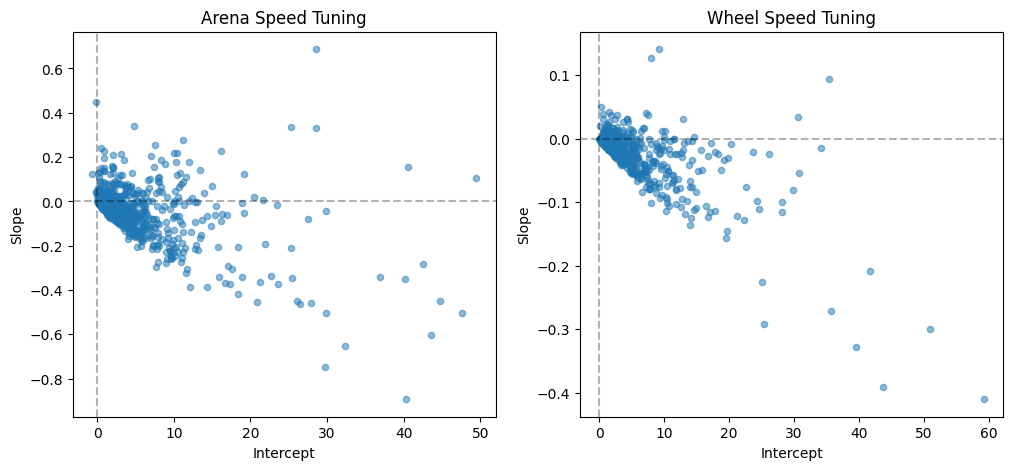

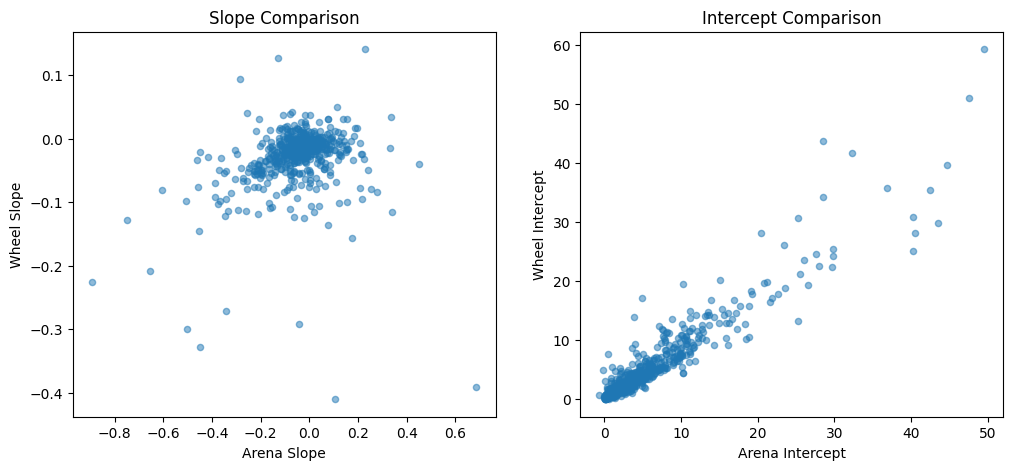

In [518]:



    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#well_fit = (explore.oa_r2 > 0.5) | (explore.wh_r2 > 0.5)

# Arena tuning
ax1.scatter(explore.oa_offset, explore.oa_slope, alpha=0.5, s=20)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('Intercept')
ax1.set_ylabel('Slope')
ax1.set_title('Arena Speed Tuning')

# Wheel tuning
ax2.scatter(explore.wh_offset, explore.wh_slope, alpha=0.5, s=20)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Intercept')
ax2.set_ylabel('Slope')
ax2.set_title('Wheel Speed Tuning')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Compare slopes across contexts
ax1.scatter(explore.oa_slope, explore.wh_slope, alpha=0.5, s=20)
ax1.set_xlabel('Arena Slope')
ax1.set_ylabel('Wheel Slope')
ax1.set_title('Slope Comparison')

# Compare offsets across contexts
ax2.scatter(explore.oa_offset, explore.wh_offset, alpha=0.5, s=20)
ax2.set_xlabel('Arena Intercept')
ax2.set_ylabel('Wheel Intercept')
ax2.set_title('Intercept Comparison')



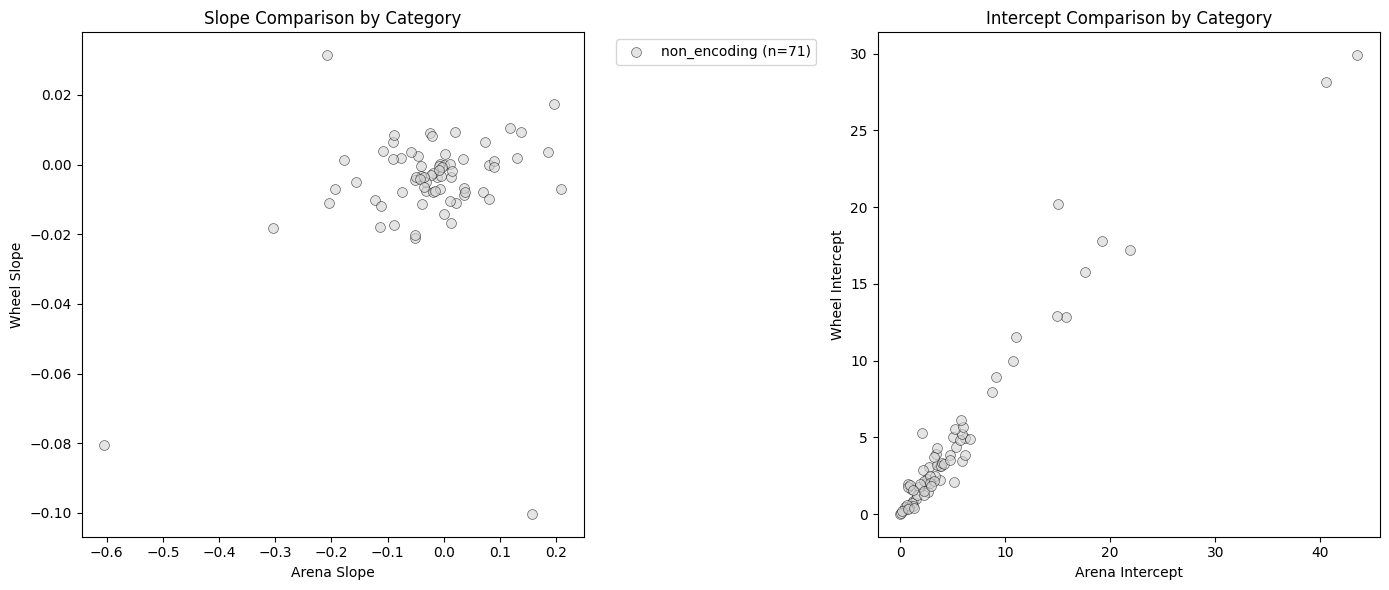

In [524]:
# Define colors for each category
colors = {
    #'context_invariant': 'black',
    #'arena_only': 'green', 
    #'wheel_only': 'purple',
    #'context_switching': 'orange',
    'non_encoding': 'lightgray'
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot each category separately
for cat, color in colors.items():
    if hasattr(explore, cat):
        mask = getattr(explore, cat) #& well_fit
        if np.sum(mask) > 0:
            ax1.scatter(explore.oa_slope[mask], explore.wh_slope[mask], 
                       c=color, label=f'{cat} (n={np.sum(mask)})', 
                       alpha=0.6, s=50, edgecolor='k', linewidth=0.5)

            ax2.scatter(explore.oa_offset[mask], explore.wh_offset[mask], 
                       c=color, alpha=0.6, s=50, edgecolor='k', linewidth=0.5)


ax1.set_xlabel('Arena Slope')
ax1.set_ylabel('Wheel Slope')
ax1.set_title('Slope Comparison by Category')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

max_offset = np.nanmax(np.concatenate([explore.oa_offset, explore.wh_offset]))
ax2.set_xlabel('Arena Intercept')
ax2.set_ylabel('Wheel Intercept')
ax2.set_title('Intercept Comparison by Category')

plt.tight_layout()

In [120]:

def get_reliability_Stability(session):

        r_oa_1= session.r_oa_first_half
        r_oa_2 = session.r_oa_second_half
        r_wh_1= session.r_wh_first_half
        r_wh_2= session.r_wh_second_half
        r_oa_1_2 = session.oa_stability
        r_wh_1_2 = session.wh_stability


        r_oa_1_wh_2 = np.corrcoef(r_oa_1, r_wh_2) [0,1]
        r_oa_2_wh_1 = np.corrcoef(r_oa_2, r_wh_1) [0,1]


        session.reliability = np.sqrt(r_oa_1_2* r_wh_1_2) 

        
        z1 = np.arctanh(r_oa_1_wh_2)
        z2 = np.arctanh(r_oa_2_wh_1)

        z_mean = (z1 + z2 ) / 2
        session.stability = np.tanh(z_mean)

In [ ]:
def plot_reliability_stability(all_session):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['xtick.major.width'] = 1.5
    plt.rcParams['ytick.major.width'] = 1.5
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6

    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=300)

    reliability_values = []
    stability_values = []
    brain_regions = []

    for session in all_sessions:
        
        reliability_values.append(session.reliability)
        stability_values.append(session.stability)
        
    
        if session.subject_id[:2] == 'EB':
            brain_regions.append('Hippocampus')
        else:
            brain_regions.append('Secondary Motor Cortex')


    reliability_values = np.array(reliability_values)
    stability_values = np.array(stability_values)
    brain_regions = np.array(brain_regions)


    colors = {
        'Hippocampus':"#132B97",  
        'Secondary Motor Cortex':"#690B0B" 
    }  
    for region in ['Hippocampus', 'Secondary Motor Cortex']:
        mask = brain_regions == region
        
        ax.scatter(reliability_values[mask], 
                stability_values[mask], 
                c=colors[region],
                s=100,  
                alpha=0.7,  
                edgecolors='none',  
                linewidth=0.5,
                label=region,
                zorder=3)

    ax.plot([0, 1], [0, 1], 'k-', linewidth=1.5, alpha=0.5, zorder=1)

    ax.set_xlim(-0.10, 1.05)
    ax.set_ylim(-0.10, 1.05)

    ax.set_xlabel('reliability within context', fontsize=16)
    ax.set_ylabel('stability between contexts', fontsize=16)

    # Add legend
    legend = ax.legend(loc='upper left', 
                    frameon=True, 
                    fancybox=False,
                    edgecolor='black',
                    fontsize=12)
    legend.get_frame().set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)


    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()

In [118]:
sesh =load_and_process_session(subject_id, date, target_freq=10)
sesh = analyze_single_session(sesh)


(array([], dtype=int64),)
DEBUG: n_neurons = 819
DEBUG: Arena mask sum = 39258 / 55129 time points
DEBUG: Wheel mask sum = 15642 / 55129 time points
DEBUG: Arena speed shape = (55129,), unique values = 55128
DEBUG: Wheel speed shape = (55129,), unique values = 26849
DEBUG: Total spikes in arena = 7629167.0
DEBUG: Total spikes in wheel = 3318447.0
DEBUG: Neurons with arena variance > 0: 819
DEBUG: Neurons with wheel variance > 0: 819
DEBUG: Good neurons = 819 / 819
DEBUG: r_oa NaNs = 0
DEBUG: r_wh NaNs = 0
DEBUG: r_oa range = [-0.186, 0.320]
DEBUG: r_wh range = [-0.344, 0.370]
DEBUG: Arena speed variance = 7.94207171427573
DEBUG: Wheel speed variance = 143.90923496567723


NameError: name 'all_sessions' is not defined

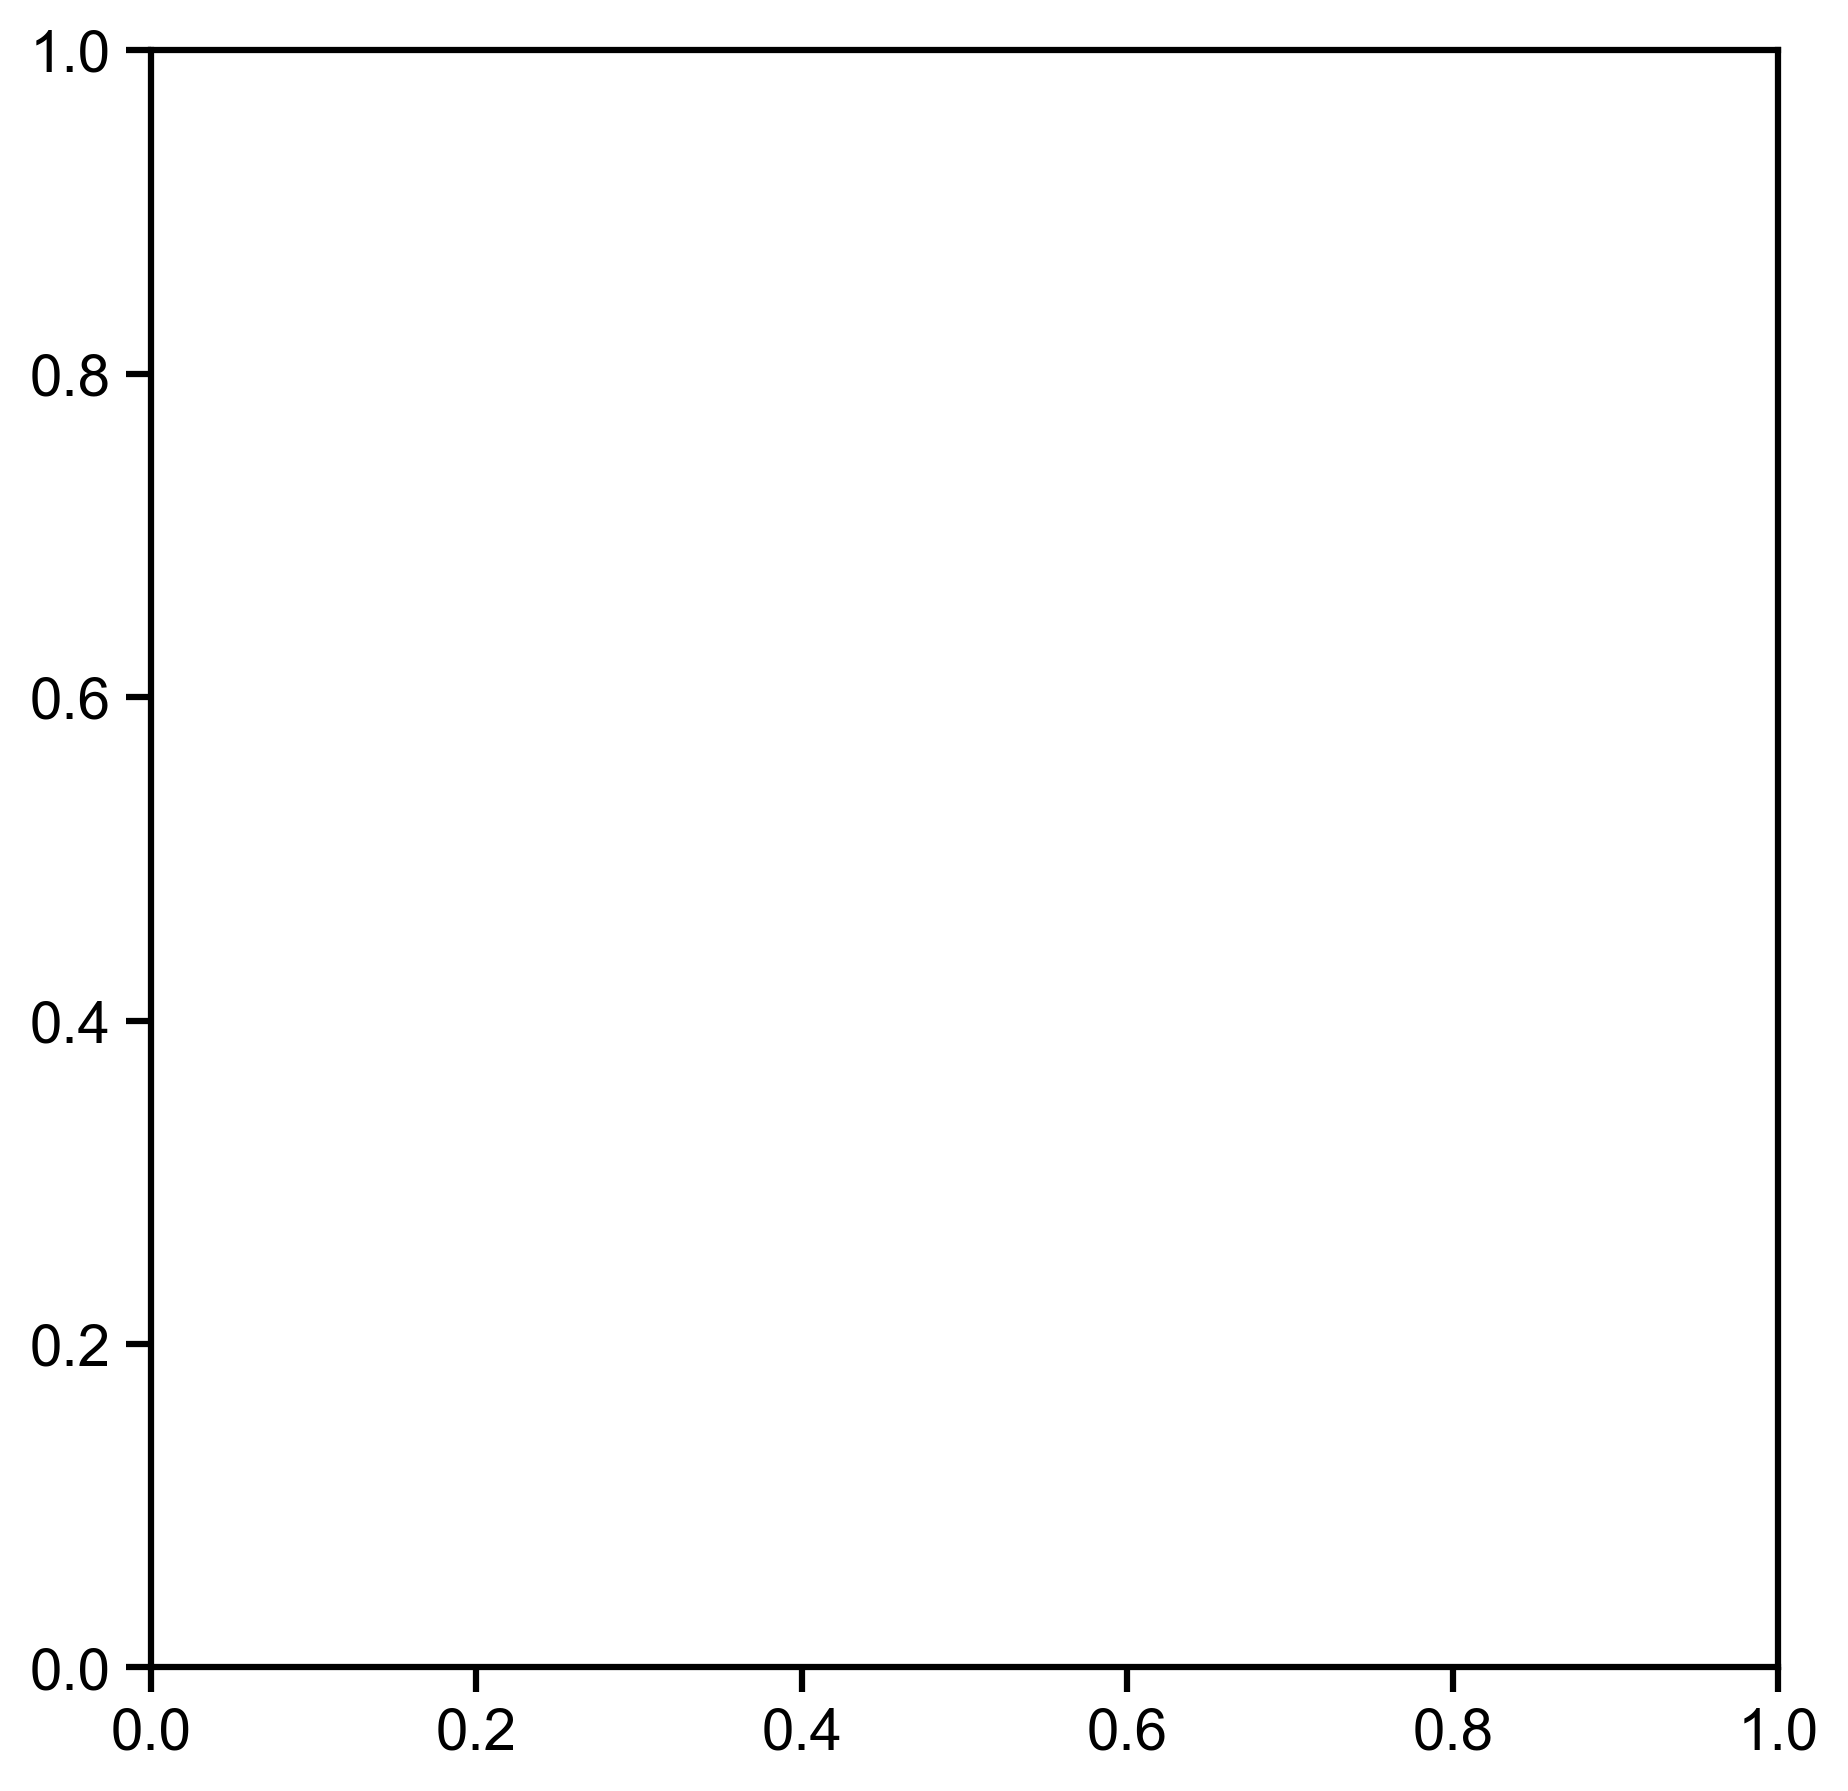

In [124]:
get_reliability_Stability(sesh)
plot_reliability_stability(sesh)


neck: 482 NaN frames for x (0.3%)
neck: 482 NaN frames for y (0.3%)
mid_back: 1371 NaN frames for x (0.9%)
mid_back: 1371 NaN frames for y (0.9%)
mouse_center: 206 NaN frames for x (0.1%)
mouse_center: 206 NaN frames for y (0.1%)
mid_backend: 460 NaN frames for x (0.3%)
mid_backend: 460 NaN frames for y (0.3%)
mid_backend2: 1770 NaN frames for x (1.2%)
mid_backend2: 1770 NaN frames for y (1.2%)
mid_backend3: 2292 NaN frames for x (1.5%)
mid_backend3: 2292 NaN frames for y (1.5%)


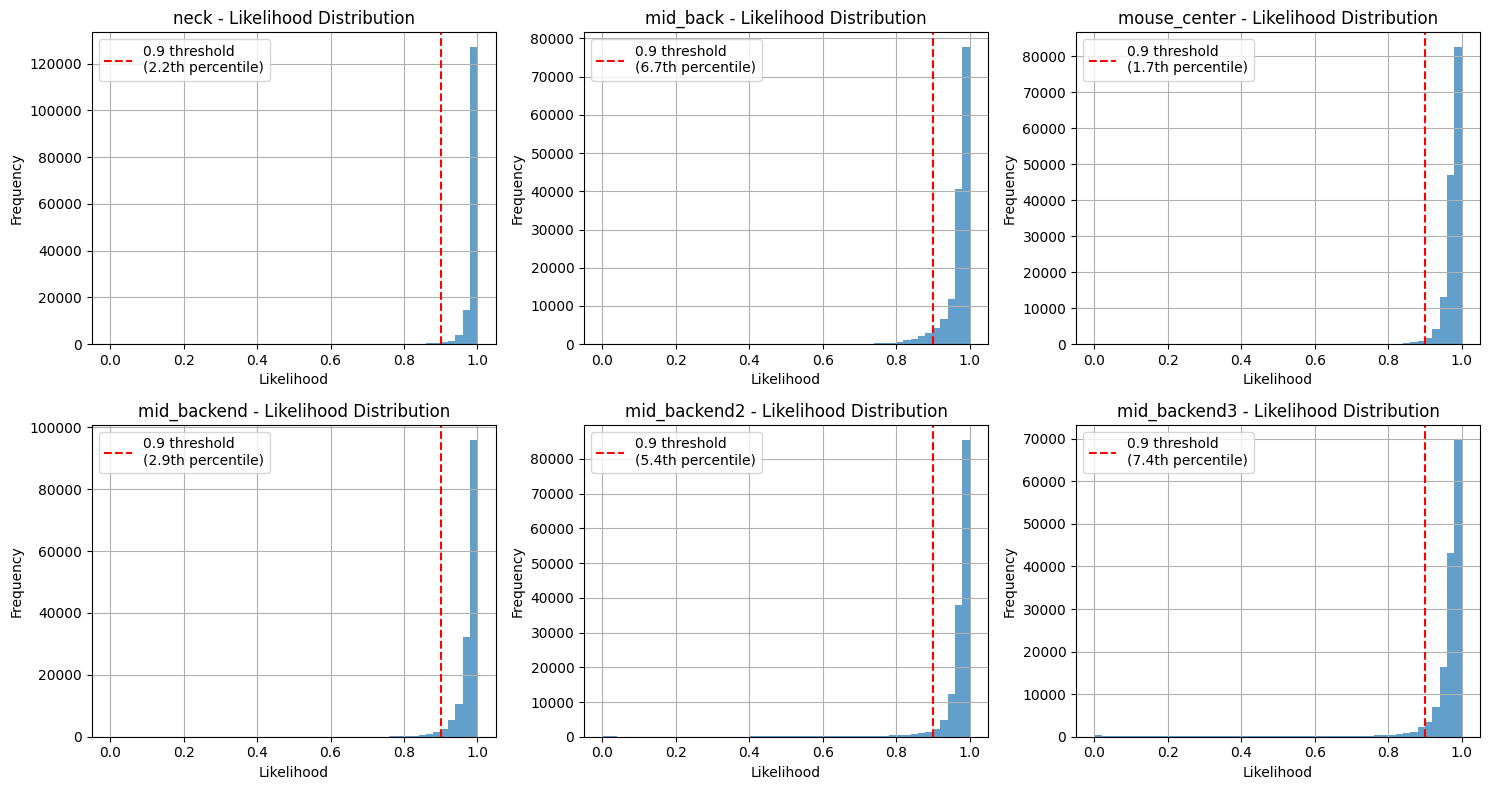

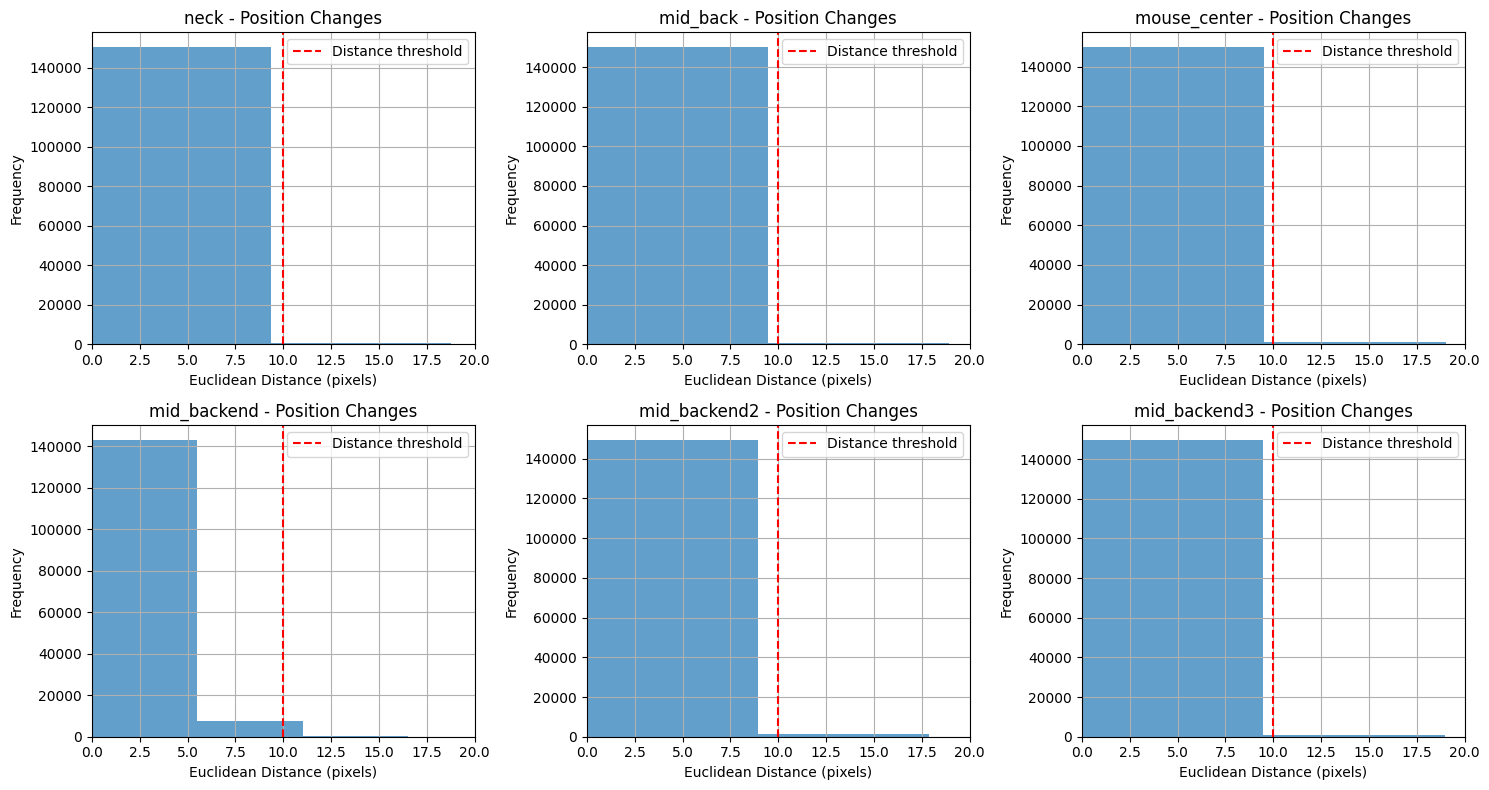

neck: 482 NaN frames for x (0.3%)
neck: 482 NaN frames for y (0.3%)
mid_back: 1371 NaN frames for x (0.9%)
mid_back: 1371 NaN frames for y (0.9%)
mouse_center: 206 NaN frames for x (0.1%)
mouse_center: 206 NaN frames for y (0.1%)
mid_backend: 460 NaN frames for x (0.3%)
mid_backend: 460 NaN frames for y (0.3%)
mid_backend2: 1770 NaN frames for x (1.2%)
mid_backend2: 1770 NaN frames for y (1.2%)
mid_backend3: 2292 NaN frames for x (1.5%)
mid_backend3: 2292 NaN frames for y (1.5%)


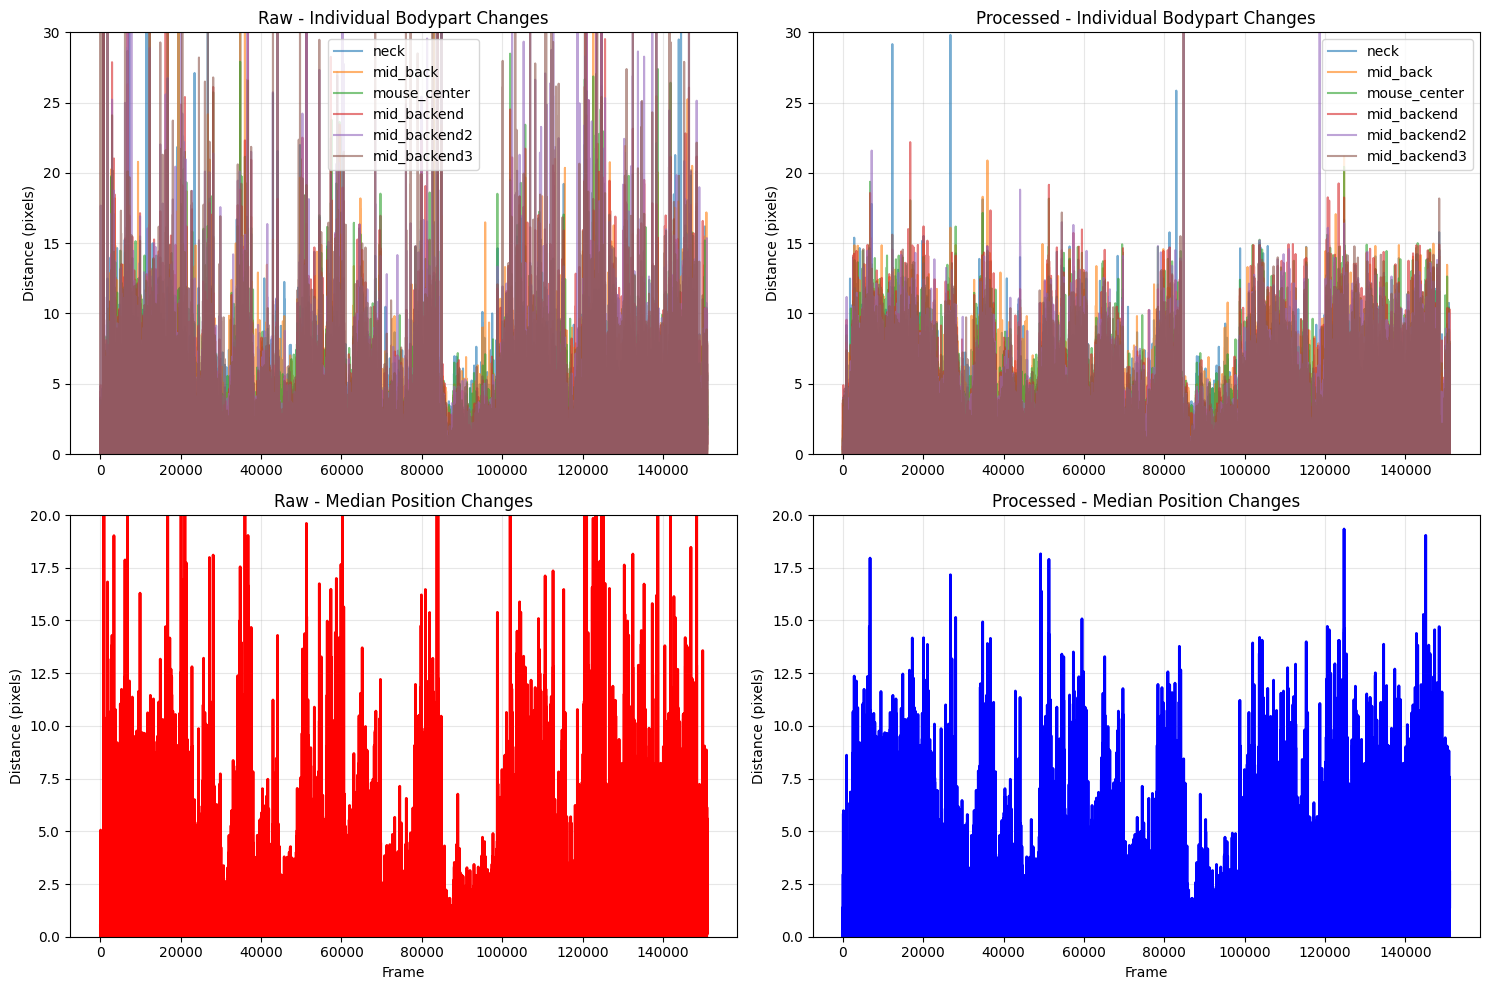

In [12]:
dlc_df = get_dlc_df(subject_id, date)
preprocess_dlc_data(dlc_df)
plot_dlc_analyses(dlc_df, w_start=0, w_end=400000)